In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from math import pi
from scipy.signal import butter, filtfilt, freqz
from scipy.spatial import ConvexHull 
from filterpy.kalman import KalmanFilter
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy import signal
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq    
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



def smooth_data(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def format_data_to_2f(df):
    formatted_df = df.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
    return formatted_df


file_path = '1220-7.csv' #here to change the file you want to analyze, which should be under the same catagory

data = pd.read_csv(file_path, header=None)



display(data.head())
data = data.iloc[1000:] #remove the 1000th data
data = data.iloc[::50] #20 data per second
#plt.plot(data[:,0])

display(data)
time = data.to_numpy()
#plt.plot(time[:,0])
#$display(time)
#display(data.head())
raw_data = data.to_numpy()

raw_data = raw_data.astype(float)
#raw_data[:, 1] = raw_data[:, 0:3] * 9.81
#display(raw_data)
raw_data[:, 0]  = butter_lowpass_filter(raw_data[:, 0], cutoff=5, fs=20, order=8)






,0
0,0.087155
1,0.087155
2,0.083934
3,0.079425
4,0.076526


,0
1000,0.079747
1050,0.078781
1100,0.079425
1150,0.079103
1200,0.078459
...,...
29750,0.070407
29800,0.051726
29850,0.074594
29900,0.087477


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal
import pandas as pd


freq_data = data.to_numpy()
freq_data = freq_data.astype(float)
freq_data[:,0] = butter_lowpass_filter(freq_data[:,0], cutoff=5, fs=20, order=8)
#freq_data[:, 0] = freq_data[:, 0].iloc[::50]
N = len(freq_data[:, 0])

fs = 50  # 採樣頻率（Hz）



# 去趨勢和平滑
data_filtered = signal.detrend(freq_data[:, 0])  # 去趨勢
#data_filtered = signal.savgol_filter(data_detrend, window_length=14, polyorder=3)  # 平滑


Analysis Results:
Number of detected peaks: 27
Duration of each peak from baseline to peak (x2): ['0.400s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.100s', '0.000s', '0.000s', '0.000s', '0.000s', '0.200s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.100s', '0.000s', '0.000s', '0.000s', '0.000s']
Depth of each peak: ['0.132', '0.016', '0.035', '0.024', '0.035', '0.018', '0.095', '0.043', '0.144', '0.047', '0.008', '0.001', '0.010', '0.139', '0.021', '0.036', '0.006', '0.032', '0.030', '0.019', '0.049', '0.098', '0.125', '0.065', '0.094', '0.029', '0.024']
Total duration: 0.800s
Percentage of total time: 2.76%
{'num_peaks': 27, 'peak_positions': [39, 45, 90, 113, 146, 164, 173, 207, 278, 282, 291, 300, 304, 317, 337, 365, 390, 414, 445, 458, 466, 474, 488, 537, 555, 568, 576], 'total_duration': 0.8, 'percentage': 2.7586206896551726, 'durations': [0.4, 0, 0, 0, 0, 0, 0.0, 0.0, 0.1, 0.0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 

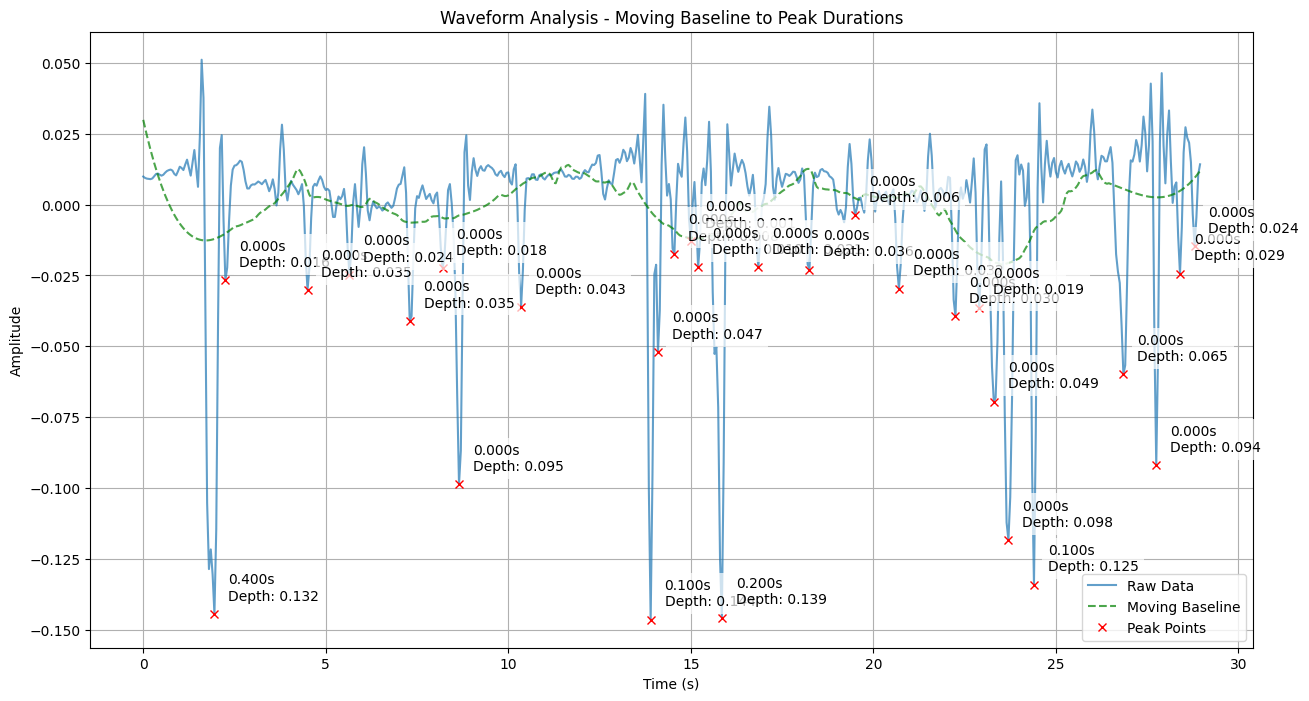

In [ ]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt

def analyze_waveform(data, sample_rate=20, window_size=101, prominence=0.02):
    """
    Analyze the peaks in a waveform using a moving baseline.
    
    Parameters:
    data: numpy array, input waveform data
    sample_rate: int, sampling rate (Hz)
    window_size: int, moving window size (for calculating the baseline)
    prominence: float, minimum prominence of the peaks
    """
    # Use Savitzky-Golay filter to compute the moving baseline
    baseline = savgol_filter(data, window_size, 3)
    
    # Find all peaks (negative peaks)
    peaks, properties = find_peaks(-data, prominence=prominence)
    
    # Calculate the duration of each peak
    durations = []
    valid_peaks = []
    depths = []
    local_baselines = []
    
    for peak in peaks:
        # Get the local baseline value at the peak position
        local_baseline = baseline[peak]
        peak_value = data[peak]
        # Calculate the depth of the peak (difference from local baseline to the peak)
        depth = local_baseline - peak_value
        
        if depth > 0:  # Ensure the peak is below the local baseline
            # Find the point where it starts to drop from the baseline
            # Search to the left
            left_idx = peak
            while left_idx > 0 and abs(data[left_idx] - local_baseline) > 0.01:
                left_idx -= 1
            
            # Calculate the time (from the start of the drop to the peak)
            time_points = peak - left_idx
            # Convert time points to seconds and multiply by 2
            duration = (time_points / sample_rate) * 2
            if duration < 1.5 and depth > 0.04:
                durations.append(duration)
            else:
                durations.append(0)
            valid_peaks.append(peak)
            depths.append(depth)
            local_baselines.append(local_baseline)
    
    # Compute statistics
    total_duration = np.sum(durations)
    total_time = len(data) / sample_rate
    percentage = (total_duration / total_time) * 100
    
    # Plot the results
    time_array = np.arange(len(data)) / sample_rate
    plt.figure(figsize=(15, 8))
    
    # Plot the raw data
    plt.plot(time_array, data, label='Raw Data', alpha=0.7)
    # Plot the moving baseline
    plt.plot(time_array, baseline, 'g--', label='Moving Baseline', alpha=0.7)
    # Plot the peaks
    plt.plot(np.array(valid_peaks) / sample_rate, data[valid_peaks], "rx", label='Peak Points')
    
    # Annotate each peak
    for peak, duration, local_base, depth in zip(valid_peaks, durations, local_baselines, depths):
        plt.annotate(f'{duration:.3f}s\nDepth: {depth:.3f}', 
                    xy=(peak/sample_rate, data[peak]),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform Analysis - Moving Baseline to Peak Durations')
    plt.legend()
    plt.grid(True)
    
    return {
        'num_peaks': len(valid_peaks),
        'peak_positions': valid_peaks,
        'total_duration': total_duration,
        'percentage': percentage,
        'durations': durations,
        'depths': depths
    }

def analyze_and_print_results(wave_data, sample_rate=20):
    results = analyze_waveform(wave_data, sample_rate=sample_rate)
    
    print(f"Analysis Results:")
    print(f"Number of detected peaks: {results['num_peaks']}")
    print(f"Duration of each peak from baseline to peak (x2): {[f'{d:.3f}s' for d in results['durations']]}")
    print(f"Depth of each peak: {[f'{d:.3f}' for d in results['depths']]}")
    print(f"Total duration: {results['total_duration']:.3f}s")
    print(f"Percentage of total time: {results['percentage']:.2f}%")
    
    return results


print(analyze_and_print_results(data_filtered))


Analysis Results:
Number of detected peaks: 28
Duration of each peak from baseline to peak (x2): ['0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s', '0.000s']
Depth of each peak: ['0.064', '0.035', '0.025', '0.007', '0.021', '0.013', '0.012', '0.028', '0.039', '0.042', '0.042', '0.020', '0.041', '0.033', '0.034', '0.018', '0.020', '0.024', '0.032', '0.040', '0.029', '0.037', '0.043', '0.022', '0.040', '0.044', '0.030', '0.021']
Total duration: 0.000s
Percentage of total time: 0.00%
{'num_peaks': 28, 'peak_positions': [32, 43, 76, 97, 121, 153, 168, 177, 275, 285, 297, 302, 310, 320, 343, 387, 398, 431, 455, 462, 470, 479, 491, 520, 552, 558, 562, 571], 'total_duration': 0, 'percentage': 0.0, 'durations': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

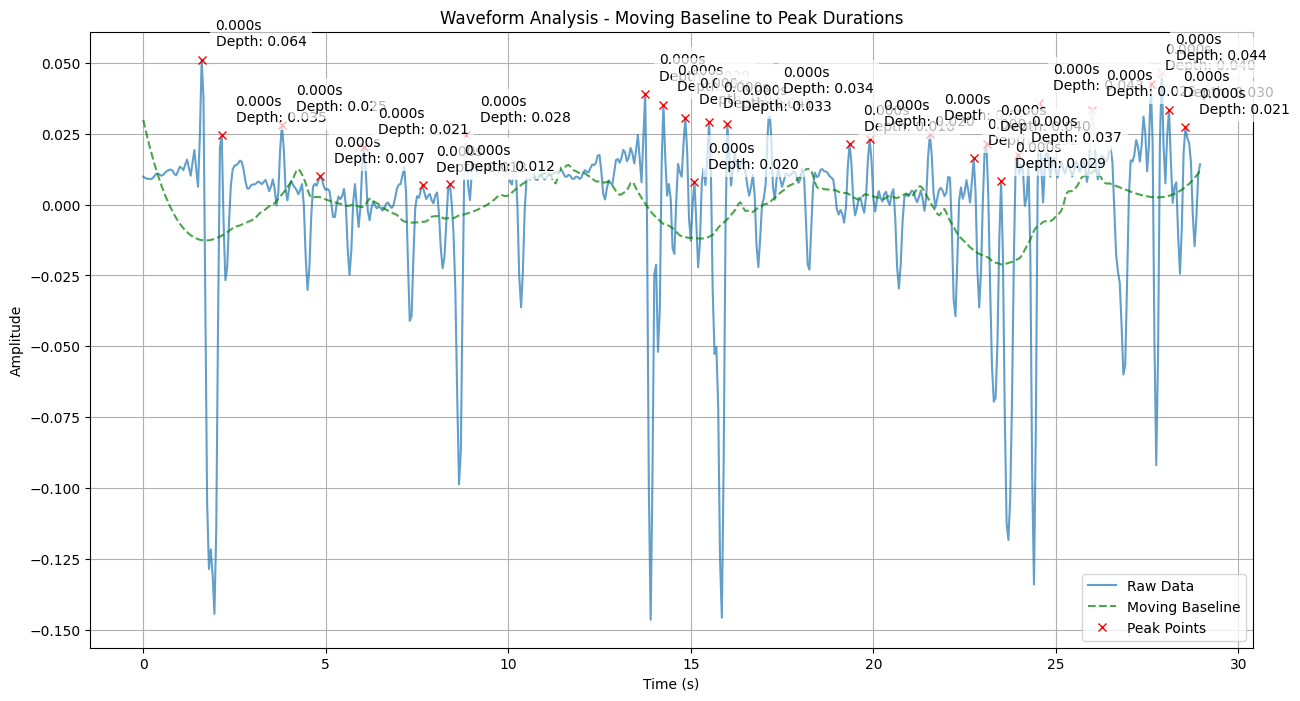

In [18]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt

def analyze_waveform(data, sample_rate=20, window_size=101, prominence=0.02):
    """
    Analyze the peaks in a waveform using a moving baseline.
    
    Parameters:
    data: numpy array, input waveform data
    sample_rate: int, sampling rate (Hz)
    window_size: int, moving window size (for calculating the baseline)
    prominence: float, minimum prominence of the peaks
    """
    # Use Savitzky-Golay filter to compute the moving baseline
    baseline = savgol_filter(data, window_size, 3)
    
    # Find all peaks
    peaks, properties = find_peaks(data, prominence=prominence)
    
    # Calculate the duration of each peak
    durations = []
    valid_peaks = []
    depths = []
    local_baselines = []
    
    for peak in peaks:
        # Get the local baseline value at the peak position
        local_baseline = baseline[peak]
        peak_value = data[peak]
        # Calculate the depth of the peak (difference from the peak to the local baseline)
        depth = peak_value - local_baseline  
        
        if depth > 0:  # Ensure the peak is above the local baseline
            # Find the point where it starts to rise from the baseline
            # Search to the left
            left_idx = peak
            while left_idx > 0 and abs(data[left_idx] - local_baseline) > 0.01:
                left_idx -= 1
            
            # Calculate the time (from the start of the rise to the peak)
            time_points = peak - left_idx
            # Convert time points to seconds and multiply by 2
            duration = (time_points / sample_rate) * 2
            if duration < 1 and depth > 0.2:
                durations.append(duration)
            else:
                durations.append(0)
            valid_peaks.append(peak)
            depths.append(depth)
            local_baselines.append(local_baseline)
    
    # Compute statistics
    total_duration = np.sum(durations)
    total_time = len(data) / sample_rate
    percentage = (total_duration / total_time) * 100
    
    # Plot the results
    time_array = np.arange(len(data)) / sample_rate
    plt.figure(figsize=(15, 8))
    
    # Plot the raw data
    plt.plot(time_array, data, label='Raw Data', alpha=0.7)
    # Plot the moving baseline
    plt.plot(time_array, baseline, 'g--', label='Moving Baseline', alpha=0.7)
    # Plot the peaks
    plt.plot(np.array(valid_peaks) / sample_rate, data[valid_peaks], "rx", label='Peak Points')
    
    # Annotate each peak
    for peak, duration, local_base, depth in zip(valid_peaks, durations, local_baselines, depths):
        plt.annotate(f'{duration:.3f}s\nDepth: {depth:.3f}', 
                    xy=(peak/sample_rate, data[peak]),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform Analysis - Moving Baseline to Peak Durations')
    plt.legend()
    plt.grid(True)
    
    return {
        'num_peaks': len(valid_peaks),
        'peak_positions': valid_peaks,
        'total_duration': total_duration,
        'percentage': percentage,
        'durations': durations,
        'depths': depths
    }

def analyze_and_print_results(wave_data, sample_rate=20):
    results = analyze_waveform(wave_data, sample_rate=sample_rate)
    
    print(f"Analysis Results:")
    print(f"Number of detected peaks: {results['num_peaks']}")
    print(f"Duration of each peak from baseline to peak (x2): {[f'{d:.3f}s' for d in results['durations']]}")
    print(f"Depth of each peak: {[f'{d:.3f}' for d in results['depths']]}")
    print(f"Total duration: {results['total_duration']:.3f}s")
    print(f"Percentage of total time: {results['percentage']:.2f}%")
    
    return results


print(analyze_and_print_results(data_filtered))
